In [36]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

from skimage.segmentation import clear_border
img = cv.imread('matricula_2.jpeg')
img_gris = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [37]:
kernel = np.ones((3,3), np.uint8)

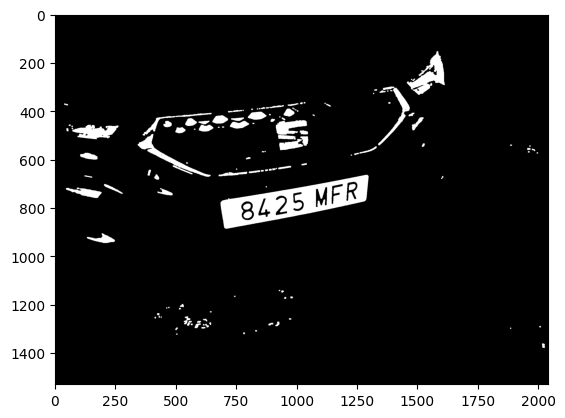

In [38]:
median = cv.medianBlur(img_gris, 3)
ret, th = cv.threshold(median, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
kernel = np.ones((5,5), np.uint8)
opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel)
edge_touching_removed = clear_border(opening)
contours, hierarchy = cv.findContours(edge_touching_removed, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
plt.imshow(edge_touching_removed, cmap="gray")

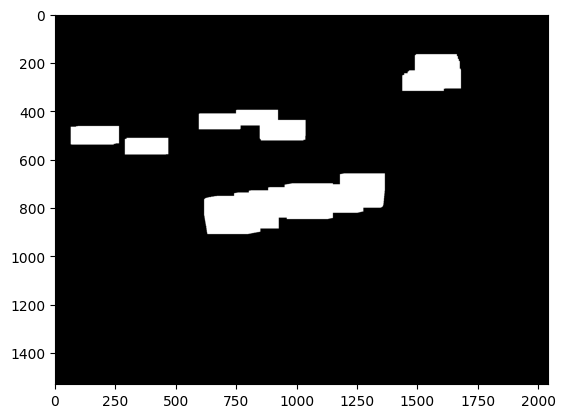

In [39]:
img_erosion = cv.erode(edge_touching_removed, kernel, iterations=7)
img_dilation = cv.dilate(img_erosion, kernel, iterations=7)
img_dilation = cv.dilate(img_dilation, np.ones((2,9), np.uint8), iterations=15)
img_dilation = cv.dilate(img_dilation, kernel, iterations=5)
plt.imshow(img_dilation, cmap="gray")

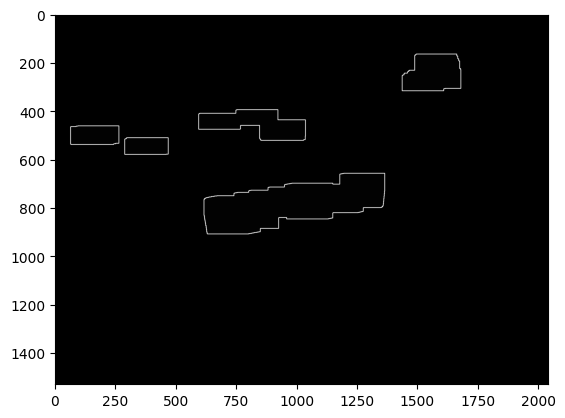

In [40]:
cnts,_=cv.findContours(cv.Canny(img_dilation,100,200),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
contornos =  cv.drawContours((img_dilation//255),cnts,-1,(100,100,100),2)
plt.imshow(contornos, cmap="gray")

In [42]:
contornos_millor=cnts[0]
area_max=0
for c in cnts:
    area = cv.contourArea(c)
    if area>area_max:#len(approx)==4 and area>4000:
        area_max=area
        contornos_millor=c
        x,y,w,h = cv.boundingRect(c)

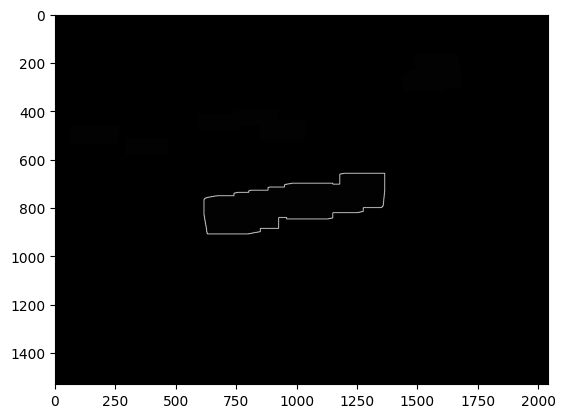

In [43]:
aux=cv.drawContours(img_dilation//255,[contornos_millor],0,(100,100,100),2)
plt.imshow(aux, cmap="gray")

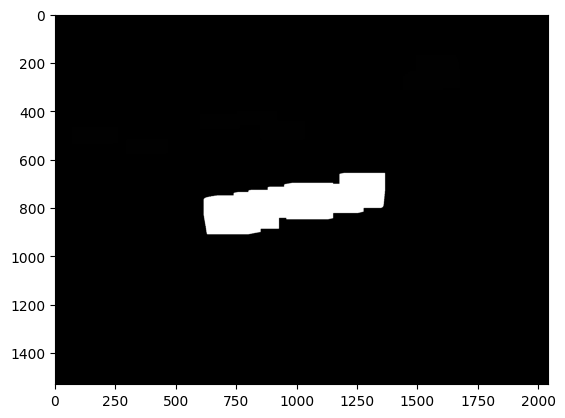

In [44]:
im_floodfill = ((aux>2) * aux).copy()
 
h, w = aux.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
 
# Floodfill from point (0, 0)
cv.floodFill(im_floodfill, mask, (0,0), 255)
 
# Invert floodfilled image
im_floodfill_inv = cv.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
im_out = aux | im_floodfill_inv
 
plt.imshow( im_out,cmap="gray")

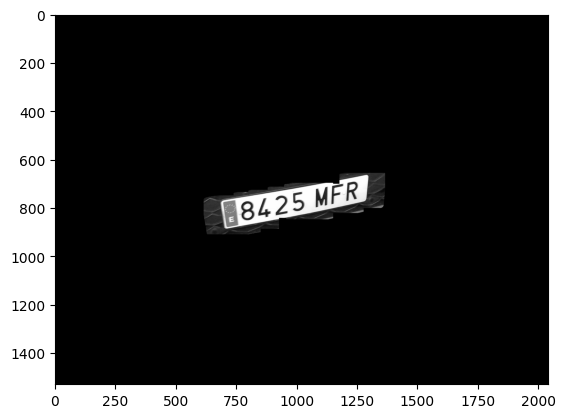

In [45]:
imagen_final=img_gris*(im_out>200)
plt.imshow(imagen_final,cmap="gray")

In [49]:
x,y,w,h

(0, 658, 2040, 1530)

In [46]:
x=0
x_superior=0
tamany=imagen_final.shape
x_inferior=tamany[0]
for fila in imagen_final:
    for cela in fila:
        if cela>0:
            x_inferior=x
    x+=1
for fila in imagen_final:
    for cela in fila:
        if cela>0:
            x_superior=x
    x-=1

In [56]:
x=0
y=0
y_superior=0
tamany=imagen_final.shape
y_inferior=tamany[1]
valor=imagen_final[x,y]
while valor<1:
    x+=1
    if x>tamany[0]-1:
        x=0
        y+=1
    valor=imagen_final[x,y]
y_esquerra=y

In [54]:
x,y

(766, 615)

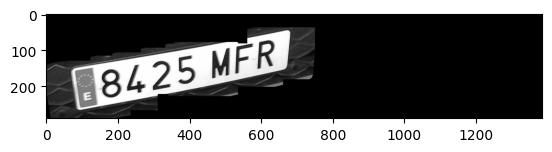

In [59]:
plt.imshow(imagen_final[x_superior:x_inferior,y_esquerra:2000],cmap="gray")

In [48]:
imagen_final.shape

(1530, 2040)